# Learner algorithm for RC-dependencies, bigrams of container nodes

Loading in the data and the required packages:

In [1]:
import math
import numpy as np
import pandas as pd
from nltk.util import ngrams
from nltk.probability import FreqDist
from learner_functions import get_ngrams, get_freq_dist, get_prob, plot_log_prob_simple

In [2]:
path = "../corpus-parsing/output_rc_corrected_oct23.xlsx"
data = pd.read_excel(path)

In [3]:
data.head(10)

,Sent_id,Graph_id,Web_id,Sentence,All_paths,Chosen_path,Comment
0,s407343,s1245_690_c_11862,1245,En dag som vi alle var samlet sammen med menne...,"['TOPIC-REL', 'ADJUNCT $ SUBJ']",ADJUNCT,MANUALLY CHECKED
1,s308196,s145_221_c_309782,145,Dagen etter at lady Helena var kommet tilbake ...,"['TOPIC-REL', 'ADJUNCT $ SUBJ']",ADJUNCT,MANUALLY CHECKED
2,s189044,s810_13_c_9831,810,"Hun het Gudrun til fornavn, og så står datoen ...","['TOPIC-REL', 'ADJUNCT $ SUBJ']",ADJUNCT,MANUALLY CHECKED
3,s381049,s2363_75_c_17545,2363,Om Silje kjenner det som hun svikter Zorba da ...,"['TOPIC-REL', 'ADJUNCT $_adv OBJ']",ADJUNCT,MANUALLY CHECKED
4,s336298,s593_13_c_4944,593,Nå tenker jeg du gjør som vi sier!,"['TOPIC-REL', 'ADJUNCT $_adv OBJ']",ADJUNCT,MANUALLY CHECKED
5,s346605,s224_31_c_8996,224,"Hun gjorde en pause, som hun alltid gjorde når...","['TOPIC-REL', 'ADJUNCT $_adv OBJ']",ADJUNCT,MANUALLY CHECKED
6,s315396,s623_10_c_8141,623,Et øyeblikk senere stod Kevin på samme plass s...,"['TOPIC-REL', 'ADJUNCT $_adv OBJ']",ADJUNCT,MANUALLY CHECKED
7,s310398,s2347_188_c_88274,2347,Men nå som det ikke er noen som helst grunn fo...,"['TOPIC-REL', 'COMP_wh-int OBJ']",ADJUNCT,MANUALLY CHECKED
8,s441019,s81_478_c_16047,81,'Foreldrene mine blir så rare hver gang det er...,"['TOPIC-REL', 'FOCUS PREDLINK OBL-TH']",ADJUNCT,MANUALLY CHECKED
9,s230425,s2498_0_c_4167,2498,Men det var ikke derfor hun slikket.,"['TOPIC-REL', 'GVN-TOP_nominal COMP_nominal OBJ']",ADJUNCT,MANUALLY CHECKED


## We start by exploring the input data for the learner by calculating:
- the total number of dependencies
- unique f-structure labels
- certain dependency counts etc.

In [4]:
data["Chosen_path"].describe()  # To see the number of filler-gap paths, how many of them are unique etc.

count     40702
unique      110
top        SUBJ
freq      16418
Name: Chosen_path, dtype: object

In [5]:
unique = data["Chosen_path"].unique()  # Another way to find unique paths
len(unique)

110

In [6]:
unique  # All of the possible paths

array(['ADJUNCT', 'ADJUNCT OBJ', 'COMP XCOMP OBJ', 'COMP_inf ADJUNCT OBJ',
       'COMP_inf OBJ', 'COMP_inf OBL-TH', 'COMP_nominal PREDLINK',
       'COMP_nominal SUBJ', 'COMP_nominal XCOMP ADJUNCT',
       'COMP_nominal XCOMP ADJUNCT OBJ', 'COMP_nominal XCOMP OBJ',
       'COMP_som OBL-TH', 'OBJ', 'OBJ ADJUNCT OBJ', 'OBJ SPEC POSS',
       'OBL-TH', 'PREDLINK', 'PREDLINK ADJUNCT OBJ',
       'PREDLINK ADJUNCT OBJ ADJUNCT OBJ', 'PREDLINK COMP OBJ',
       'PREDLINK COMP XCOMP OBJ', 'PREDLINK OBJ',
       'PREDLINK SUBJ SPEC POSS', 'PREDLINK XCOMP OBJ', 'SUBJ',
       'XCOMP ADJUNCT', 'XCOMP ADJUNCT OBJ', 'XCOMP COMP OBJ',
       'XCOMP COMP_nominal PREDLINK', 'XCOMP COMP_nominal SUBJ',
       'XCOMP OBJ', 'XCOMP OBJ ADJUNCT OBJ', 'XCOMP OBJ OBL-TH',
       'XCOMP OBJ SPEC POSS', 'XCOMP OBL-TH', 'XCOMP OBL-TH SPEC POSS',
       'XCOMP SUBJ', 'XCOMP XCOMP OBJ', 'XCOMP XCOMP SUBJ',
       'COMP_wh-int SUBJ', 'COMP_pol-int SUBJ', 'COMP_pol-int XCOMP SUBJ',
       'COMP_pol-int OBJ', 'COMP_

In [7]:
# Short dependencies consisting of only one f-label 
i = 0
for p in data["Chosen_path"]:
    if " " not in p:
        i+=1
i/len(data["Chosen_path"])*100  # Percentage of one-label paths

66.59623605719621

In [8]:
# All f-structure labels
labels_set = set()
labels_arr = list()
for string in data['Chosen_path']:
    seq = str(string).split()
    for label in seq:
        labels_set.add(label)
        labels_arr.append(label)
len(labels_set)  # Number of unique labels

16

In [9]:
labels_set

{'ADJUNCT',
 'COMP',
 'COMP_inf',
 'COMP_nominal',
 'COMP_pol-int',
 'COMP_som',
 'COMP_wh-int',
 'OBJ',
 'OBJ-BEN',
 'OBL-AG',
 'OBL-TH',
 'POSS',
 'PREDLINK',
 'SPEC',
 'SUBJ',
 'XCOMP'}

In [10]:
# The percentage that the 7 most common labels constitute
labels_common = ["ADJUNCT", "COMP_nominal", "OBJ", "OBL-TH", "PREDLINK", "SUBJ", "XCOMP"]
c = 0
for l in labels_arr:
    if l in labels_common:
        c +=1
c/len(labels_arr)*100

99.40612478534631

In [11]:
counts = data["Chosen_path"].value_counts()
paths_to_get_counts_for = ["SUBJ", "OBJ", "PREDLINK", # Short dependencies
                           "COMP_nominal SUBJ", "COMP_nominal OBJ", # Dependencies into embedded declaratives
                           "COMP_wh-int SUBJ", "COMP_wh-int OBJ", # Dependencies into embedded interrogative questions
                           "COMP_pol-int SUBJ", "COMP_pol-int OBJ"] # Dependencies into embedded polar questions

In [12]:
for path in paths_to_get_counts_for:
    try:
        print(path, counts[path])
    except KeyError:
        print(path, "No examples of such dependency found")

SUBJ 16418
OBJ 7934
PREDLINK 1010
COMP_nominal SUBJ 11
COMP_nominal OBJ 81
COMP_wh-int SUBJ 20
COMP_wh-int OBJ No examples of such dependency found
COMP_pol-int SUBJ 1
COMP_pol-int OBJ 1


## Now we split the input data for into n-grams and calculate the frequency distribution:

In [13]:
# Set n-gram window size
n_gram = 2

In [14]:
all_ngrams = []
for string in data['Chosen_path']:
    seq = str(string).split()
    n_grams = get_ngrams(seq, n_gram)
    for ngr in n_grams:
        all_ngrams.append(ngr)
                
freq_dist = get_freq_dist(all_ngrams)
print('20 most common container node n-grams:')
for i in freq_dist.most_common(20):
    print(i)

20 most common container node n-grams:
(('SUBJ', 'end'), 21240)
(('start', 'SUBJ'), 16418)
(('OBJ', 'end'), 15459)
(('start', 'XCOMP'), 11226)
(('start', 'OBJ'), 7964)
(('XCOMP', 'OBJ'), 4777)
(('XCOMP', 'SUBJ'), 4755)
(('ADJUNCT', 'OBJ'), 2484)
(('start', 'ADJUNCT'), 2253)
(('OBL-TH', 'end'), 1861)
(('start', 'PREDLINK'), 1378)
(('PREDLINK', 'end'), 1276)
(('start', 'OBL-TH'), 1028)
(('XCOMP', 'ADJUNCT'), 775)
(('ADJUNCT', 'end'), 620)
(('XCOMP', 'OBL-TH'), 562)
(('XCOMP', 'XCOMP'), 390)
(('XCOMP', 'PREDLINK'), 311)
(('start', 'COMP_nominal'), 265)
(('PREDLINK', 'OBL-TH'), 225)


## Now we start exploring the modeling results by island type
### 1. Subject island

Plotting the modelled probabilities for four experimental conditions from the Sprouse's design

In [15]:
# get_prob returns the probability for a path, the path itself, and a list of unattested n-grams
p_short_1, path1, un1, raw1 = get_prob(['SUBJ'], freq_dist, n_gram)  # short no island
p_short_2, path2, un2, raw2 = get_prob(['SUBJ'], freq_dist, n_gram)  # short island

In [16]:
p_long_1, path3, un3, raw3 = get_prob(['COMP_nominal', 'SUBJ'], freq_dist, n_gram)  # long no island
p_long_2, path4, un4, raw4 = get_prob(['COMP_nominal', 'SUBJ', 'ADJUNCT', 'OBJ'], freq_dist, n_gram)  # long island

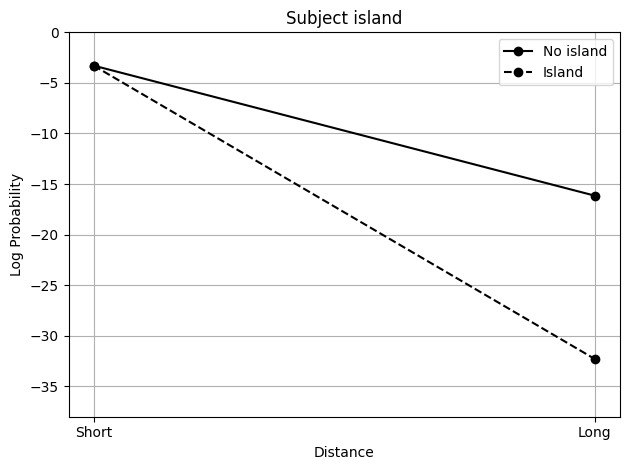

In [17]:
plot_log_prob_simple(p_short_1, p_long_1, p_short_2, p_long_2, title = "Subject island")

In [18]:
condition = []
paths = [" ".join(path1), " ".join(path2), " ".join(path3), " ".join(path4)]
probs = [p_short_1, p_short_2, p_long_1, p_long_2]
unattested = [un1, un2, un3, un4]
condition.extend(["Subject"]*4)

In [19]:
unattested

[[], [], [], [('SUBJ', 'ADJUNCT')]]

### 2. CNP island (reported in the Appendix)

In [20]:
# Short conditions are the same as previously
p_long_1, path3, un3, raw3 = get_prob(['COMP_nominal', 'OBJ'], freq_dist, n_gram)  # long no island
p_long_2, path4, un4, raw4 = get_prob(['OBJ', 'COMP_nominal', 'OBJ'], freq_dist, n_gram)  # long island

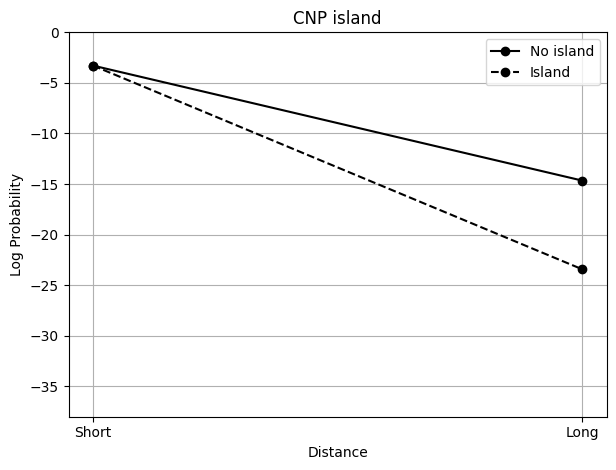

In [21]:
plot_log_prob_simple(p_short_1, p_long_1, p_short_2, p_long_2, title = "CNP island")

In [22]:
paths.extend([" ".join(path1), " ".join(path2), " ".join(path3), " ".join(path4)])
probs.extend([p_short_1, p_short_2, p_long_1, p_long_2])
unattested.extend([un1, un2, un3, un4])
condition.extend(["CNP"]*4)

### 3. EQ island (comp_wh-int), subject extraction

In [23]:
# Short conditions as defined previously
p_long_1, path3, un3, raw3 = get_prob(['COMP_nominal', 'SUBJ'], freq_dist, n_gram)  # long no island
p_long_2, path4, un4, raw4 = get_prob(['COMP_wh-int', 'SUBJ'], freq_dist, n_gram)  # long island

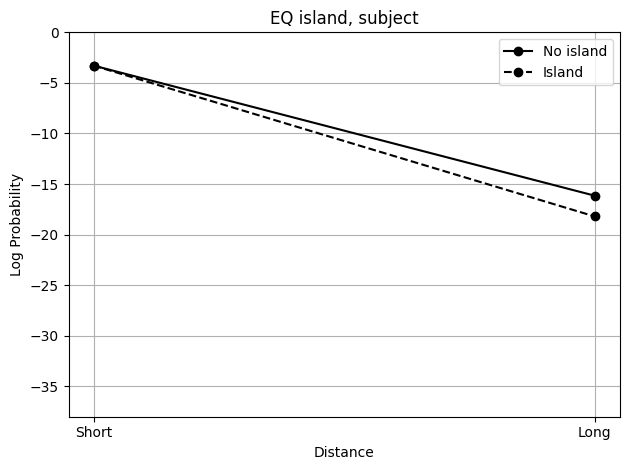

In [24]:
plot_log_prob_simple(p_short_1, p_long_1, p_short_2, p_long_2, title = "EQ island, subject")

In [25]:
paths.extend([" ".join(path1), " ".join(path2), " ".join(path3), " ".join(path4)])
probs.extend([p_short_1, p_short_2, p_long_1, p_long_2])
unattested.extend([un1, un2, un3, un4])
condition.extend(["EQ"]*4)

### 4. EQ island (comp_wh-int), object extraction (reported in the Appendix)

In [26]:
p_short_1, path1, un1, raw1 = get_prob(['OBJ'], freq_dist, n_gram)  # short no island
p_short_2, path2, un2, raw2 = get_prob(['OBJ'], freq_dist, n_gram)  # short island
p_long_1, path3, un3, raw3 = get_prob(['COMP_nominal', 'OBJ'], freq_dist, n_gram)  # long no island
p_long_2, path4, un4, raw4 = get_prob(['COMP_wh-int', 'OBJ'], freq_dist, n_gram)  # long island

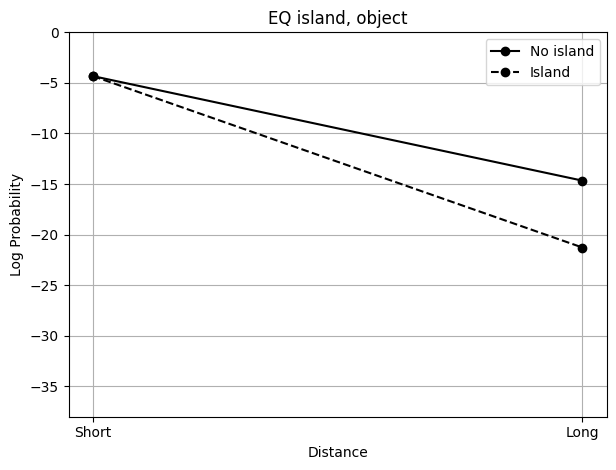

In [27]:
plot_log_prob_simple(p_short_1, p_long_1, p_short_2, p_long_2, title = "EQ island, object")

In [28]:
paths.extend([" ".join(path1), " ".join(path2), " ".join(path3), " ".join(path4)])
probs.extend([p_short_1, p_short_2, p_long_1, p_long_2])
unattested.extend([un1, un2, un3, un4])
condition.extend(["EQ-object"]*4)

### 5. Whether island (comp_pol-int), subject extraction (reported in the Appendix)

In [29]:
p_short_1, path1, un1, raw1 = get_prob(['SUBJ'], freq_dist, n_gram)  # short no island
p_short_2, path2, un2, raw2 = get_prob(['SUBJ'], freq_dist, n_gram)  # short island
p_long_1, path3, un3, raw3 = get_prob(['COMP_nominal', 'SUBJ'], freq_dist, n_gram)  # long no island
p_long_2, path4, un4, raw4 = get_prob(['COMP_pol-int', 'SUBJ'], freq_dist, n_gram)  # long island

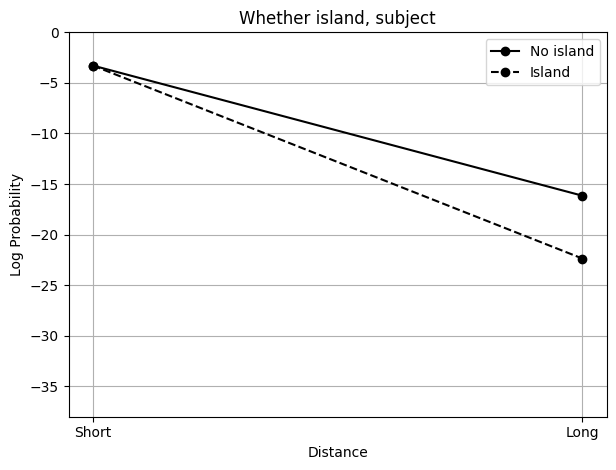

In [30]:
plot_log_prob_simple(p_short_1, p_long_1, p_short_2, p_long_2, title = "Whether island, subject")

In [31]:
paths.extend([" ".join(path1), " ".join(path2), " ".join(path3), " ".join(path4)])
probs.extend([p_short_1, p_short_2, p_long_1, p_long_2])
unattested.extend([un1, un2, un3, un4])
condition.extend(["Whether-subject"]*4)

### 6. Whether island (comp_pol-int), object extraction (reported in the Appendix)

In [32]:
p_short_1, path1, un1, raw1 = get_prob(['OBJ'], freq_dist, n_gram)  # short no island
p_short_2, path2, un2, raw2 = get_prob(['OBJ'], freq_dist, n_gram)  # short island
p_long_1, path3, un3, raw3 = get_prob(['COMP_nominal', 'OBJ'], freq_dist, n_gram)  # long no island
p_long_2, path4, un4, raw4 = get_prob(['COMP_pol-int', 'OBJ'], freq_dist, n_gram)  # long island

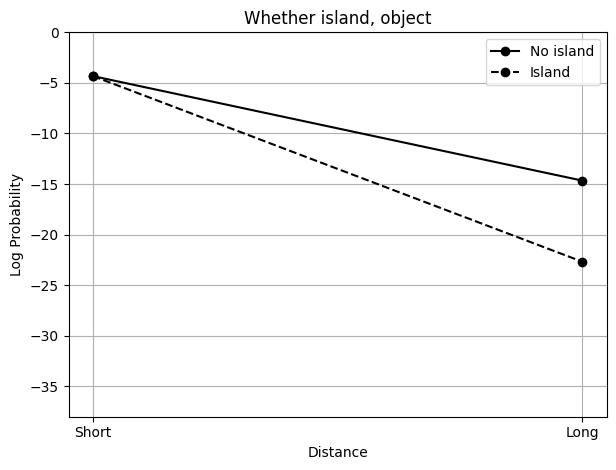

In [33]:
plot_log_prob_simple(p_short_1, p_long_1, p_short_2, p_long_2, title = "Whether island, object")

In [34]:
paths.extend([" ".join(path1), " ".join(path2), " ".join(path3), " ".join(path4)])
probs.extend([p_short_1, p_short_2, p_long_1, p_long_2])
unattested.extend([un1, un2, un3, un4])
condition.extend(["Whether-object"]*4)

### 7. Adjunct island

In [35]:
p_short_1, path1, un1, raw1 = get_prob(['SUBJ'], freq_dist, n_gram)  # short no island
p_short_2, path2, un2, raw2 = get_prob(['SUBJ'], freq_dist, n_gram)  # short island
p_long_1, path3, un3, raw3 = get_prob(['COMP_nominal', 'OBJ'], freq_dist, n_gram)  # long no island
p_long_2, path4, un4, raw4 = get_prob(['ADJUNCT_adv', 'OBJ'], freq_dist, n_gram)  # long island

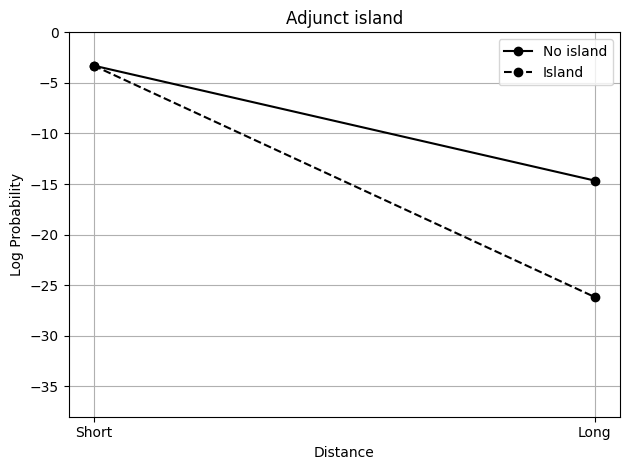

In [36]:
plot_log_prob_simple(p_short_1, p_long_1, p_short_2, p_long_2, title = "Adjunct island")

In [37]:
paths.extend([" ".join(path1), " ".join(path2), " ".join(path3), " ".join(path4)])
probs.extend([p_short_1, p_short_2, p_long_1, p_long_2])
unattested.extend([un1, un2, un3, un4])
condition.extend(["Adjunct"]*4)

### 8. RC island, object extraction, predlink as comparison

In [38]:
p_short_1, path1, un1, raw1 = get_prob(['SUBJ'], freq_dist, n_gram)  # short no island
p_short_2, path2, un2, raw2 = get_prob(['PREDLINK'], freq_dist, n_gram)  # short island
p_long_2, path4, un4, raw4 = get_prob(['ADJUNCT_rel', 'OBJ'], freq_dist, n_gram)  # long island

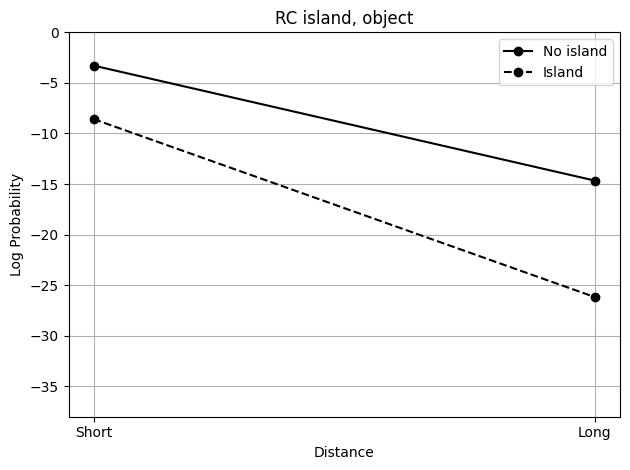

In [39]:
plot_log_prob_simple(p_short_1, p_long_1, p_short_2, p_long_2, title = "RC island, object")

In [40]:
paths.extend([" ".join(path1), " ".join(path2), " ".join(path3), " ".join(path4)])
probs.extend([p_short_1, p_short_2, p_long_1, p_long_2])
unattested.extend([un1, un2, un3, un4])
condition.extend(["RC-predlink"]*4)

### 9. RC island, subject extraction, subj as comparison

In [41]:
p_short_1, path1, un1, raw1 = get_prob(['SUBJ'], freq_dist, n_gram)  # short no island
p_short_2, path2, un2, raw2 = get_prob(['SUBJ'], freq_dist, n_gram)  # short island
p_long_1, path3, un3, raw3 = get_prob(['COMP_nominal', 'SUBJ'], freq_dist, n_gram)  # long no island
p_long_2, path4, un4, raw4 = get_prob(['ADJUNCT_rel', 'SUBJ'], freq_dist, n_gram)  # long island

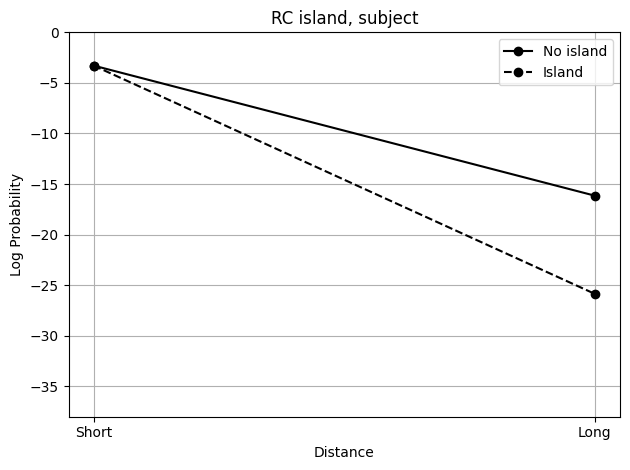

In [42]:
plot_log_prob_simple(p_short_1, p_long_1, p_short_2, p_long_2, title = "RC island, subject")

In [43]:
paths.extend([" ".join(path1), " ".join(path2), " ".join(path3), " ".join(path4)])
probs.extend([p_short_1, p_short_2, p_long_1, p_long_2])
unattested.extend([un1, un2, un3, un4])
condition.extend(["RC-subject"]*4)

## 10. RC island, P-comp extraction

In [44]:
p_short_1, path1, un1, raw1 = get_prob(['SUBJ'], freq_dist, n_gram)  # short no island
p_short_2, path2, un2, raw2 = get_prob(['SUBJ'], freq_dist, n_gram)  # short island
p_long_1, path3, un3, raw3 = get_prob(['COMP_nominal', 'ADJUNCT', 'OBJ'], freq_dist, n_gram)  # long no island
p_long_2, path4, un4, raw4 = get_prob(['ADJUNCT_rel', 'ADJUNCT', 'OBJ'], freq_dist, n_gram)  # long island

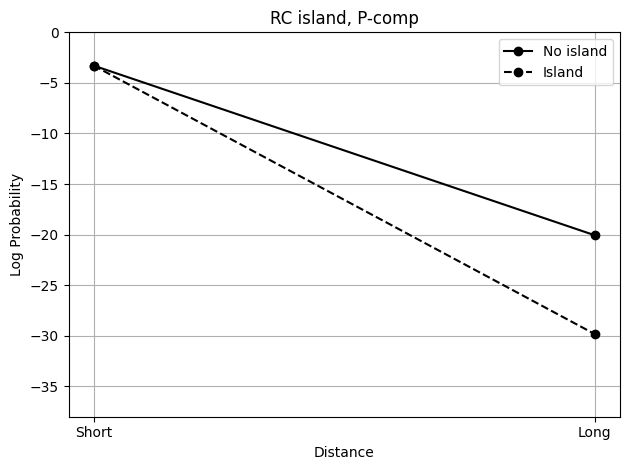

In [45]:
plot_log_prob_simple(p_short_1, p_long_1, p_short_2, p_long_2, title = "RC island, P-comp")

In [46]:
paths.extend([" ".join(path1), " ".join(path2), " ".join(path3), " ".join(path4)])
probs.extend([p_short_1, p_short_2, p_long_1, p_long_2])
unattested.extend([un1, un2, un3, un4])
condition.extend(["RC-Pcomp"]*4)

In [47]:
structure = ["noIsland", "Island", "noIsland", "Island"]*10

In [48]:
distance = ["Short", "Short", "Long", "Long"]*10

In [49]:
dependency = ["RC"]*40
n_gram_size = ["Bigram"]*40

In [50]:
df = pd.DataFrame(list(zip(condition, distance, structure, paths, probs, unattested, dependency, n_gram_size)),
               columns =['condition', 'distance', 'structure', 'path', 'log_probability', 
                         'unattested_ngrams', 'dependency', 'n_gram'])

In [51]:
df.to_csv('../results-visualization/data/model_results_rc_bigrams.csv', index=False)

In [52]:
# All bigrams and their frequency
for key,value in sorted(freq_dist.items()):
    print(key,value)

('ADJUNCT', 'OBJ') 2484
('ADJUNCT', 'SUBJ') 24
('ADJUNCT', 'end') 620
('COMP', 'ADJUNCT') 2
('COMP', 'OBJ') 15
('COMP', 'OBJ-BEN') 1
('COMP', 'OBL-TH') 4
('COMP', 'PREDLINK') 2
('COMP', 'XCOMP') 2
('COMP_inf', 'ADJUNCT') 13
('COMP_inf', 'OBJ') 19
('COMP_inf', 'OBL-TH') 5
('COMP_nominal', 'ADJUNCT') 16
('COMP_nominal', 'COMP') 1
('COMP_nominal', 'COMP_nominal') 3
('COMP_nominal', 'OBJ') 94
('COMP_nominal', 'OBJ-BEN') 1
('COMP_nominal', 'OBL-TH') 6
('COMP_nominal', 'PREDLINK') 48
('COMP_nominal', 'SUBJ') 15
('COMP_nominal', 'XCOMP') 133
('COMP_nominal', 'end') 12
('COMP_pol-int', 'OBJ') 1
('COMP_pol-int', 'SUBJ') 1
('COMP_pol-int', 'XCOMP') 3
('COMP_som', 'OBL-TH') 1
('COMP_wh-int', 'OBJ') 1
('COMP_wh-int', 'SUBJ') 23
('COMP_wh-int', 'XCOMP') 2
('OBJ', 'ADJUNCT') 3
('OBJ', 'COMP') 15
('OBJ', 'OBJ') 1
('OBJ', 'OBJ-BEN') 1
('OBJ', 'OBL-TH') 31
('OBJ', 'SPEC') 2
('OBJ', 'end') 15459
('OBJ-BEN', 'end') 220
('OBL-AG', 'end') 9
('OBL-TH', 'SPEC') 1
('OBL-TH', 'end') 1861
('POSS', 'end') 4
('PR

In [53]:
# Df with results
df.head(8)

,condition,distance,structure,path,log_probability,unattested_ngrams,dependency,n_gram
0,Subject,Short,noIsland,start SUBJ end,-3.287791,[],RC,Bigram
1,Subject,Short,Island,start SUBJ end,-3.287791,[],RC,Bigram
2,Subject,Long,noIsland,start COMP_nominal SUBJ end,-16.150310,[],RC,Bigram
3,Subject,Long,Island,start COMP_nominal SUBJ ADJUNCT OBJ end,-32.300937,"[(SUBJ, ADJUNCT)]",RC,Bigram
4,CNP,Short,noIsland,start SUBJ end,-3.287791,[],RC,Bigram
5,CNP,Short,Island,start SUBJ end,-3.287791,[],RC,Bigram
6,CNP,Long,noIsland,start COMP_nominal OBJ end,-14.660237,[],RC,Bigram
7,CNP,Long,Island,start OBJ COMP_nominal OBJ end,-23.431059,"[(OBJ, COMP_nominal)]",RC,Bigram


## Bootstrapping CI for modeling estimates

In [54]:
all_sent_paths = data['Chosen_path'].tolist() # array of strings that represent f-structure paths

In [55]:
to_test = df['path'].tolist()

In [56]:
num_samples = 1000

# Arrays to be populated within a loop, to be merged into a df later
bootstrap_res = []
bootstrap_seq = []
bootstrap_unat = []
bootstrap_sample_num = []
bootstrap_dep = dependency*num_samples
bootstrap_n_gram = n_gram_size*num_samples
bootstrap_condition = condition*num_samples
bootstrap_structure = structure*num_samples
bootstrap_distance = distance*num_samples

In [57]:
# Perform bootstrap sampling
for i in range(num_samples):
    sample_ngrams = []
    bootstrap_sample = np.random.choice(all_sent_paths, size=len(all_sent_paths), replace=True)
    for path in bootstrap_sample:
        path_els = str(path).split()
        n_grams = get_ngrams(path_els, n_gram)
        for ngr in n_grams:
            sample_ngrams.append(ngr)
    sample_freq_dist = get_freq_dist(sample_ngrams)
    for path in to_test: 
        path_arr = path.split()[1:-1] # get prob inserts start and end nodes
        result = get_prob(path_arr, sample_freq_dist, n_gram)
        bootstrap_res.append(result[3]) # non-log prob
        bootstrap_seq.append(result[1]) # test seq
        bootstrap_unat.append(result[2]) # unat ngrams within test seq
        bootstrap_sample_num.append(i+1) # sample num

In [58]:
boot_df = pd.DataFrame(list(zip(bootstrap_condition, bootstrap_distance, bootstrap_structure, bootstrap_seq, 
                                bootstrap_res, bootstrap_unat, bootstrap_dep, bootstrap_n_gram, bootstrap_sample_num)),
               columns =['condition', 'distance', 'structure', 'path', 'raw_probability', 'unattested_ngrams', 
                         'dependency', 'n_gram', 'bootstrap_sample'])

In [59]:
boot_df

,condition,distance,structure,path,raw_probability,unattested_ngrams,dependency,n_gram,bootstrap_sample
0,Subject,Short,noIsland,"[start, SUBJ, end]",3.719283e-02,[],RC,Bigram,1
1,Subject,Short,Island,"[start, SUBJ, end]",3.719283e-02,[],RC,Bigram,1
2,Subject,Long,noIsland,"[start, COMP_nominal, SUBJ, end]",7.227302e-08,[],RC,Bigram,1
3,Subject,Long,Island,"[start, COMP_nominal, SUBJ, ADJUNCT, OBJ, end]",6.834869e-15,"[(SUBJ, ADJUNCT)]",RC,Bigram,1
4,CNP,Short,noIsland,"[start, SUBJ, end]",3.719283e-02,[],RC,Bigram,1
...,...,...,...,...,...,...,...,...,...
39995,RC-subject,Long,Island,"[start, ADJUNCT_rel, SUBJ, end]",5.838058e-12,"[(start, ADJUNCT_rel), (ADJUNCT_rel, SUBJ)]",RC,Bigram,1000
39996,RC-Pcomp,Short,noIsland,"[start, SUBJ, end]",3.673491e-02,[],RC,Bigram,1000
39997,RC-Pcomp,Short,Island,"[start, SUBJ, end]",3.673491e-02,[],RC,Bigram,1000
39998,RC-Pcomp,Long,noIsland,"[start, COMP_nominal, ADJUNCT, OBJ, end]",1.444920e-09,[],RC,Bigram,1000


In [60]:
boot_df.to_csv('../results-visualization/data/bootstrap_results_rc_bigrams.csv', index=False)